<a id='1.3'></a>
## 2.3. Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
# matplotlib.use('Agg')
import datetime

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader
from finrl.meta.preprocessor.preprocessors import FeatureEngineer, data_split
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from finrl.meta.data_processor import DataProcessor

#from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from finenv.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline
from pprint import pprint

import sys
sys.path.append("../FinRL")

import itertools
import random
import json

<a id='1.4'></a>
## 2.4. Create Folders

In [2]:
from finrl import config
from finrl import config_tickers
import os
from finrl.main import check_and_make_directories
from finrl.config import (
    DATA_SAVE_DIR,
    TRAINED_MODEL_DIR,
    TENSORBOARD_LOG_DIR,
    RESULTS_DIR,
    TRAIN_START_DATE,
    TRAIN_END_DATE,
    TEST_START_DATE,
    TEST_END_DATE,
    TRADE_START_DATE,
    TRADE_END_DATE,
)
print(f"DATA_SAVE_DIR: {DATA_SAVE_DIR}")
#check_and_make_directories([DATA_SAVE_DIR, TRAINED_MODEL_DIR, TENSORBOARD_LOG_DIR, RESULTS_DIR])



DATA_SAVE_DIR: datasets


<a id='2'></a>
# Part 3. Download Data
Yahoo Finance provides stock data, financial news, financial reports, etc. Yahoo Finance is free.
* FinRL uses a class **YahooDownloader** in FinRL-Meta to fetch data via Yahoo Finance API
* Call Limit: Using the Public API (without authentication), you are limited to 2,000 requests per hour per IP (or up to a total of 48,000 requests a day).

In [3]:
# from config.py, TRAIN_START_DATE is a string
print(f"TRAIN_START_DATE: {TRAIN_START_DATE}")
# from config.py, TRAIN_END_DATE is a string
print(f"TRAIN_END_DATE: {TRAIN_END_DATE}")

TRAIN_START_DATE: 2014-01-06
TRAIN_END_DATE: 2020-07-31


In [9]:
TRAIN_START_DATE = '2010-01-01'
TRAIN_END_DATE = '2020-01-01'
TRADE_START_DATE = '2020-01-02'
TRADE_END_DATE = '2023-04-01'

In [10]:
if os.path.exists("extra/yahoo_data.csv"):
    df = pd.read_csv("extra/yahoo_data.csv", index_col=0)
else:
    df = YahooDownloader(
        start_date = TRAIN_START_DATE,
        end_date = TRADE_END_DATE,
        ticker_list = config_tickers.NAS_100_TICKER
    ).fetch_data()
    if not os.path.exists("extra"):
        os.makedirs("extra")
    df.to_csv("extra/yahoo_data.csv")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- XLNX: No timezone found, symbol may be delisted
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

In [9]:
print(config_tickers.DOW_30_TICKER)

['AXP', 'AMGN', 'AAPL', 'BA', 'CAT', 'CSCO', 'CVX', 'GS', 'HD', 'HON', 'IBM', 'INTC', 'JNJ', 'KO', 'JPM', 'MCD', 'MMM', 'MRK', 'MSFT', 'NKE', 'PG', 'TRV', 'UNH', 'CRM', 'VZ', 'V', 'WBA', 'WMT', 'DIS', 'DOW']


In [12]:
df.sort_values(['date','tic'],ignore_index=True).tail()

,date,open,high,low,close,volume,tic,day
97548,2023-03-24,468.980011,476.880005,467.589996,475.989990,2533200,UNH,4
97549,2023-03-24,220.669998,221.330002,218.250000,221.039993,4791500,V,4
97550,2023-03-24,37.529999,37.700001,37.250000,37.660000,14957700,VZ,4
97551,2023-03-24,32.380001,32.790001,31.860001,32.700001,8105300,WBA,4
97552,2023-03-24,141.009995,142.470001,140.600006,141.800003,7584100,WMT,4


# Part 4: Preprocess Data
We need to check for missing data and do feature engineering to convert the data point into a state.
* **Adding technical indicators**. In practical trading, various information needs to be taken into account, such as historical prices, current holding shares, technical indicators, etc. Here, we demonstrate two trend-following technical indicators: MACD and RSI.
* **Adding turbulence index**. Risk-aversion reflects whether an investor prefers to protect the capital. It also influences one's trading strategy when facing different market volatility level. To control the risk in a worst-case scenario, such as financial crisis of 2007–2008, FinRL employs the turbulence index that measures extreme fluctuation of asset price.

In [13]:
INDICATORS = ['macd','rsi_14', 'rsi_21','rsi_28',
 'boll_ub',
 'boll_lb',
 'rsi_30',
 'cci_30',
 'dx_30',
 'close_30_sma',
 'close_60_sma']

In [14]:
fe = FeatureEngineer(
    use_technical_indicator=True,
    tech_indicator_list = INDICATORS,
    use_vix=True,
    use_turbulence=True,
    user_defined_feature = False
)
processed = fe.preprocess_data(df)

Successfully added technical indicators
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (3328, 8)
Successfully added vix
Successfully added turbulence index


In [15]:
list_ticker = processed["tic"].unique().tolist()
list_date = list(pd.date_range(processed['date'].min(),processed['date'].max()).astype(str))
combination = list(itertools.product(list_date,list_ticker))

processed_full = pd.DataFrame(combination,columns=["date","tic"]).merge(processed,on=["date","tic"],how="left")
processed_full = processed_full[processed_full['date'].isin(processed['date'])]
processed_full = processed_full.sort_values(['date','tic'])

processed_full = processed_full.fillna(0)

In [18]:
processed_full.sort_values(['date','tic'],ignore_index=True).tail(20)

,date,tic,open,high,low,close,volume,day,macd,rsi_14,...,rsi_28,boll_ub,boll_lb,rsi_30,cci_30,dx_30,close_30_sma,close_60_sma,vix,turbulence
96492,2023-03-23,GS,315.209991,321.359985,312.640015,314.850006,2585900.0,3.0,-12.399119,36.911846,...,39.801473,373.680885,293.494579,40.251338,-99.009610,22.509771,344.307542,348.727129,22.610001,13.533911
96493,2023-03-23,HD,285.260010,286.109985,280.220001,283.910004,6005800.0,3.0,-5.803666,36.387216,...,40.842080,297.322331,281.637673,41.365357,-97.183636,28.993482,296.405750,307.710951,22.610001,13.533911
96494,2023-03-23,HON,186.860001,189.419998,185.550003,186.919998,2360100.0,3.0,-3.145101,37.784571,...,40.690171,198.656886,185.108115,41.126560,-128.632709,36.135221,194.066415,200.810197,22.610001,13.533911
96495,2023-03-23,IBM,123.809998,124.930000,122.599998,123.370003,4651900.0,3.0,-2.465890,33.477020,...,36.688263,131.850417,121.854585,37.263026,-110.989631,31.672023,129.321668,133.897389,22.610001,13.533911
96496,2023-03-23,INTC,28.379999,29.160000,28.219999,29.030001,43785500.0,3.0,0.468551,58.109139,...,54.168281,30.466031,23.753969,53.822388,80.952390,22.616393,27.224000,27.786414,22.610001,13.533911
96497,2023-03-23,JNJ,151.179993,151.690002,150.110001,151.130005,9051500.0,3.0,-2.152461,35.407257,...,36.496261,156.277143,150.428860,36.809534,-104.872194,31.282995,155.333736,162.609591,22.610001,13.533911
96498,2023-03-23,JPM,127.900002,129.529999,126.019997,126.839996,16677600.0,3.0,-3.399305,38.465405,...,42.424294,147.962102,121.972897,42.923722,-121.604856,36.766842,137.076667,137.501366,22.610001,13.533911
96499,2023-03-23,KO,60.090000,60.389999,59.720001,59.919998,15479000.0,3.0,0.113568,51.457503,...,49.719309,60.703675,58.434541,49.648368,59.864391,3.041277,59.501945,60.248045,22.610001,13.533911
96500,2023-03-23,MCD,267.989990,271.480011,267.989990,269.619995,2263800.0,3.0,1.003924,55.170691,...,53.117072,272.718056,259.980571,53.003185,106.305887,15.213954,265.798108,265.860198,22.610001,13.533911
96501,2023-03-23,MMM,101.660004,102.930000,100.760002,101.000000,3177300.0,3.0,-2.764887,31.180849,...,36.692393,112.026798,99.610201,37.210703,-127.413197,28.635478,107.736245,113.362560,22.610001,13.533911


In [ ]:
processed_full.to_csv(f'extra/yahoo_data2.csv', index=True)


In [ ]:
processed_full= pd.read_csv('extra/yahoo_data2.csv')
processed_full = processed_full.set_index(processed_full.columns[0])
processed_full.index.names = ['']

<a id='4'></a>
# Part 5. Build A Market Environment in OpenAI Gym-style
The training process involves observing stock price change, taking an action and reward's calculation. By interacting with the market environment, the agent will eventually derive a trading strategy that may maximize (expected) rewards.

Our market environment, based on OpenAI Gym, simulates stock markets with historical market data.

## Data Split
We split the data into training set and testing set as follows:

Training data period: 2009-01-01 to 2020-07-01

Trading data period: 2020-07-01 to 2021-10-31


In [19]:
train = data_split(processed_full, TRAIN_START_DATE,TRAIN_END_DATE)
trade = data_split(processed_full, TRADE_START_DATE,TRADE_END_DATE)
print(len(train))
print(len(trade))

72964
23548


In [20]:
stock_dimension = len(train.tic.unique())
state_space = 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 29, State Space: 378


In [21]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 200,
    "initial_amount": 1000000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-4
}

## Environment Creator for Training in RLLIB

* In RLLIB, an env creator is a function that take as input an EnvContext object (Dict containing the config), and outputs the envirnoment object instanciated with the parameters from the EnvContext.
* We are gonna wrap the envirnoment class in the EnvCompatibility wrapper fro *gymnasium* to account for the changes in the gym API (considered by ray 2.3.0)
* Finally, we are gonna register the environment to ray so that it would be accessible in the DRL trainers.



In [22]:
import psutil
import ray
ray._private.utils.get_system_memory = lambda: psutil.virtual_memory().total
from ray.tune.registry import register_env

from gymnasium.wrappers import EnvCompatibility

In [23]:
def env_creator(env_config):
    # env_config is passed as {} and defaults are set here
    df = env_config.get('df', train)
    hmax = env_config.get('hmax', 200)
    initial_amount = env_config.get('initial_amount', 1000000)
    num_stock_shares = env_config.get('num_stock_shares', [0] * stock_dimension)
    buy_cost_pct = env_config.get('buy_cost_pct', buy_cost_list)
    sell_cost_pct = env_config.get('sell_cost_pct', sell_cost_list)
    state_space = env_config.get('state_space', 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension)
    stock_dim = env_config.get('stock_dim', stock_dimension)
    tech_indicator_list = env_config.get('tech_indicator_list', INDICATORS)
    action_space = env_config.get('action_space', stock_dimension)
    reward_scaling = env_config.get('reward_scaling', 1e-4)

    return EnvCompatibility(StockTradingEnv(
        df=df,
        hmax=hmax,
        initial_amount=initial_amount,
        num_stock_shares=num_stock_shares,
        buy_cost_pct=buy_cost_pct,
        sell_cost_pct=sell_cost_pct,
        state_space=state_space,
        stock_dim=stock_dim,
        tech_indicator_list=tech_indicator_list,
        action_space=action_space,
        reward_scaling=reward_scaling
    ))

<a id='5'></a>
# Part 6: Train RLLIB DRL Agents
* We will initialize a ray instance specifying the resources we put at its disposal
* We will then initialize the config object from the respective default configuration of the algorithm we are going to use. We can then add environment specific parameters, and parallelization specific parameters.
* Finally, we instanciate the trainer and launch the training loop

In [1]:
from ray.rllib.agents import ppo

* Set this to True if you want to run DDPPO instead of PPO

In [25]:
use_ddppo = True

### Init ray (no need to, ray will automatically restart)

In [25]:
ray.shutdown()
print(f"ray is being initialized")
# ray.init(_temp_dir="FinRL/RLLIB/results", num_cpus=1, num_gpus=0)
# ray.init()

ray is being initialized


### Define Config

In [26]:
def pretty(d, indent=1):
    for key, value in d.items():
        print('\t' * indent + str(key) + ':')
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))

In [27]:
if use_ddppo:
    config = ppo.DDPPOConfig()
else:
    config = ppo.PPOConfig()

# Here set envirnonment parameters if different from default
config = config.environment(
    env_config={'hmax':200, 'initial_amount':1000000}
)

# Training
config = config.training()

# Resources
config = config.resources(
    num_gpus=0,
    num_cpus_per_worker=1,
    num_gpus_per_worker=0,
    num_trainer_workers=2,
    num_gpus_per_trainer_worker = 1,
    num_cpus_per_trainer_worker = 1,
)
# Framework
config = config.framework(
    framework="torch",
)
# Rollouts
config = config.rollouts(
    num_rollout_workers=16,
    num_envs_per_worker=1,
)

print(config)
# pretty(config.to_dict())

### Instanciate trainer

In [28]:
ray.shutdown()
# registering the environment to ray
register_env("finrl", env_creator)
if use_ddppo:
    trainer = ppo.DDPPOTrainer(env='finrl', config=config)
else:
    trainer = config.build(env='finrl')


2023-03-27 19:45:05,926	WARNING deprecation.py:50 -- DeprecationWarning: `algo = Algorithm(env='finrl', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('finrl').build()` instead. This will raise an error in the future!
2023-03-27 19:45:09,340	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
(RolloutWorker pid=23878) /home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/gymnasium/spaces/box.py:227: UserWarning: WARN: Casting input x to numpy array.
(RolloutWorker pid=23878)   logger.warn("Casting input x to numpy array.")
(RolloutWorker pid=23885) /home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/gymnasium/spaces/box.py:227: UserWarning: WARN: Casting input x to numpy array.
(RolloutWorker pid=23885)   logger.warn("Casting input x to numpy array.")
(RolloutWorker pid=23926) /home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/gymnasium/spaces/box.py:227: UserWarning: WARN: Casting input

### Training loop

In [29]:
from tqdm.notebook import tqdm

In [30]:
# (4) Train away -------------------------------------------------------------
total_episodes=2000
ep = 0
results = []
bar = tqdm(total=total_episodes, desc="Episodes")
from datetime import datetime
date = datetime.now().strftime('%y%m%d')
agent_name = 'ppo'
while ep <= total_episodes:
    results.append(trainer.train())
    ep += 1
    bar.update(n=1)
    rwd = results[-1]['episode_reward_mean']
    if ep % 5 == 0:
        print(f'Mean Rwd:{rwd}')
    if ep % 50 == 0:
        #cwd_checkpoint = "results/checkpoints/" +  + '_' + str(ep)
        cwd_checkpoint = f"model/{agent_name}_{date}"
        trainer.save(cwd_checkpoint)
        print(f"Checkpoint{ep} saved in directory {cwd_checkpoint}")
bar.close()

Episodes:   0%|          | 0/200 [00:00<?, ?it/s]

(RolloutWorker pid=23864) 2023-03-27 19:46:05,453	WARNING deprecation.py:50 -- DeprecationWarning: `_get_slice_indices` has been deprecated. This will raise an error in the future!
(RolloutWorker pid=23902) /home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/torch/distributed/distributed_c10d.py:1577: UserWarning: torch.distributed.all_reduce_coalesced will be deprecated. If you must use it, please revisit our documentation later at https://pytorch.org/docs/master/distributed.html#collective-functions
(RolloutWorker pid=23902)   warnings.warn(
(RolloutWorker pid=23910) /home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/torch/distributed/distributed_c10d.py:1577: UserWarning: torch.distributed.all_reduce_coalesced will be deprecated. If you must use it, please revisit our documentation later at https://pytorch.org/docs/master/distributed.html#collective-functions
(RolloutWorker pid=23910)   warnings.warn(
(RolloutWorker pid=23864) /home/ga_aiot/anaconda3/envs/finr

KeyboardInterrupt: 

In [31]:
# save the trained agent
agent_name = 'ppo'
if use_ddppo:
    agent_name = 'ddppo'
cwd_checkpoint = "FinRL/RLLIB/results/checkpoints/" + str(agent_name) + '_' + str(ep)
trainer.save(cwd_checkpoint)

'FinRL/RLLIB/results/checkpoints/ddppo_39/checkpoint_000039'

(RolloutWorker pid=28247) /home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/gymnasium/spaces/box.py:227: UserWarning: WARN: Casting input x to numpy array.
(RolloutWorker pid=28247)   logger.warn("Casting input x to numpy array.")
(RolloutWorker pid=28525) /home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/gymnasium/spaces/box.py:227: UserWarning: WARN: Casting input x to numpy array.
(RolloutWorker pid=28525)   logger.warn("Casting input x to numpy array.")
(RolloutWorker pid=28804) /home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/gymnasium/spaces/box.py:227: UserWarning: WARN: Casting input x to numpy array.
(RolloutWorker pid=28804)   logger.warn("Casting input x to numpy array.")
(RolloutWorker pid=29084) /home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/gymnasium/spaces/box.py:227: UserWarning: WARN: Casting input x to numpy array.
(RolloutWorker pid=29084)   logger.warn("Casting input x to numpy array.")
(RolloutWorker pid=29364

## In-sample Performance

Assume that the initial capital is $1,000,000.

### Set turbulence threshold
Set the turbulence threshold to be greater than the maximum of insample turbulence data. If current turbulence index is greater than the threshold, then we assume that the current market is volatile

In [53]:
data_risk_indicator = processed_full[(processed_full.date<TRAIN_END_DATE) & (processed_full.date>=TRAIN_START_DATE)]
insample_risk_indicator = data_risk_indicator.drop_duplicates(subset=['date'])

In [54]:
insample_risk_indicator.vix.describe()

count    2893.000000
mean       18.824245
std         8.489311
min         9.140000
25%        13.330000
50%        16.139999
75%        21.309999
max        82.690002
Name: vix, dtype: float64

In [55]:
insample_risk_indicator.vix.quantile(0.996)

57.40400183105453

In [35]:
insample_risk_indicator.turbulence.describe()

count    2893.000000
mean       34.567960
std        43.790812
min         0.000000
25%        14.963021
50%        24.124391
75%        39.162318
max       652.504486
Name: turbulence, dtype: float64

In [36]:
insample_risk_indicator.turbulence.quantile(0.996)

276.45255785503394

### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [37]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70, risk_indicator_col='vix', **env_kwargs)

## Environment Creator for Trading in RLLIB

* Similarly to the training env, we create an env creator for the trading environment

In [57]:
def env_creator_trading(env_config):
    # env_config is passed as {} and defaults are set here
    df = env_config.get('df', trade)  # changed from the training environment
    
    hmax = env_config.get('hmax', 100)
    initial_amount = env_config.get('initial_amount', 1000000)
    num_stock_shares = env_config.get('num_stock_shares', [0] * stock_dimension)
    buy_cost_pct = env_config.get('buy_cost_pct', buy_cost_list)
    sell_cost_pct = env_config.get('sell_cost_pct', sell_cost_list)
    state_space = env_config.get('state_space', 1 + 2*stock_dimension + len(INDICATORS)*stock_dimension)
    stock_dim = env_config.get('stock_dim', stock_dimension)
    tech_indicator_list = env_config.get('tech_indicator_list', INDICATORS)
    action_space = env_config.get('action_space', stock_dimension)
    reward_scaling = env_config.get('reward_scaling', 1e-4)
    
    # specific for trading
    turbulence_threshold = env_config.get('turbulence_threshold', 70)
    risk_indicator_col = env_config.get('risk_indicator_col', 'vix')

    return EnvCompatibility(StockTradingEnv(
        df=df,
        hmax=hmax,
        initial_amount=initial_amount,
        num_stock_shares=num_stock_shares,
        buy_cost_pct=buy_cost_pct,
        sell_cost_pct=sell_cost_pct,
        state_space=state_space,
        stock_dim=stock_dim,
        tech_indicator_list=tech_indicator_list,
        action_space=action_space,
        reward_scaling=reward_scaling,
        turbulence_threshold=turbulence_threshold,
        risk_indicator_col=risk_indicator_col
    ))

In [58]:
if ray.is_initialized():
    ray.shutdown()
#print(f"ray is being initialized")
#ray.init(_temp_dir="FinRL/RLLIB/results/trading", num_cpus=2, num_gpus=0)

In [59]:
if use_ddppo:
    config = ppo.DDPPOConfig()
else:
    config = ppo.PPOConfig()

# Here set envirnonment parameters if different from default
config = config.environment(
    env_config={'hmax':100, 'initial_amount':1000000}
)

# Training
config = config.training()

# Resources
config = config.resources(
    num_gpus=0,
    num_cpus_per_worker=1,
    num_gpus_per_worker=0,
    num_trainer_workers=2,
    num_gpus_per_trainer_worker = 0,
    num_cpus_per_trainer_worker = 1,
)
# Framework
config = config.framework(
    framework="torch",
)
# Rollouts
config = config.rollouts(
    num_rollout_workers=2,
    num_envs_per_worker=1,
)

# Additional because we are evaluating now
config = config.exploration(
    explore=False
)

print(config)
# pretty(config.to_dict())

In [60]:
ray.shutdown()
# registering the environment to ray
register_env("finrl_trading", env_creator_trading)
# define trainer
if use_ddppo:
    trainer = ppo.DDPPOTrainer(env='finrl_trading', config=config)
else:
    trainer = ppo.PPOTrainer(env='finrl_trading', config=config)

2023-03-27 19:31:49,403	WARNING deprecation.py:50 -- DeprecationWarning: `algo = Algorithm(env='finrl_trading', ...)` has been deprecated. Use `algo = AlgorithmConfig().environment('finrl_trading').build()` instead. This will raise an error in the future!
2023-03-27 19:31:52,063	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 
(RolloutWorker pid=16527) 2023-03-27 19:31:59,019	WARNING env.py:156 -- Your env doesn't have a .spec.max_episode_steps attribute. Your horizon will default to infinity, and your environment will not be reset.
(RolloutWorker pid=16527) 2023-03-27 19:31:59,019	WARNING env.py:166 -- Your env reset() method appears to take 'seed' or 'return_info' arguments. Note that these are not yet supported in RLlib. Seeding will take place using 'env.seed()' and the info dict will not be returned from reset.
(RolloutWorker pid=16527) /home/ga_aiot/anaconda3/envs/finrl/lib/python3.8/site-packages/gymnasium/spaces/box.py:227: UserW

In [61]:
# load saved agent
cwd_checkpoint = f"FinRL/RLLIB/results/checkpoints/ppo_{total_episodes+1}/checkpoint_0000{total_episodes+1}"
if use_ddppo:
    cwd_checkpoint = f"FinRL/RLLIB/results/checkpoints/ddppo_{total_episodes+1}/checkpoint_0000{total_episodes+1}"
print(f"Restoring from checkpoint {total_episodes+1}")
trainer.restore(cwd_checkpoint)

2023-03-27 19:31:59,760	INFO trainable.py:791 -- Restored on 172.24.68.30 from checkpoint: FinRL/RLLIB/results/checkpoints/ddppo_21/checkpoint_000021
2023-03-27 19:31:59,761	INFO trainable.py:800 -- Current state after restoring: {'_iteration': 21, '_timesteps_total': None, '_time_total': 133.74422454833984, '_episodes_total': 12}


Restoring from checkpoint 21


In [62]:
def DRL_prediction(model, environment):
    """make a prediction"""
    state = environment.reset()
    for i in range(len(environment.df.index.unique())):
        action = model.compute_single_action(state,explore=False)
        state, reward, done, _ = environment.step(action)
        if i == (len(environment.df.index.unique()) - 2):
            account_memory = environment.save_asset_memory()
            actions_memory = environment.save_action_memory()
        if done:
            print("hit end!")
            break
    print("Test Finished!")
    return account_memory, actions_memory

In [63]:
df_account_value, df_actions = DRL_prediction(
    model=trainer, 
    environment = e_trade_gym)

hit end!
Test Finished!


In [64]:
df_account_value.tail()

,date,account_value
331,2021-10-22,1.294914e+06
332,2021-10-25,1.294631e+06
333,2021-10-26,1.296084e+06
334,2021-10-27,1.283834e+06
335,2021-10-28,1.294662e+06


In [65]:
df_actions.head()

,AAPL,AMGN,AXP,BA,CAT,CRM,CSCO,CVX,DIS,GS,...,MRK,MSFT,NKE,PG,TRV,UNH,V,VZ,WBA,WMT
date,,,,,,,,,,,,,,,,,,,,,
2020-07-01,0,88,0,24,61,0,0,0,100,79,...,0,81,0,0,100,63,100,84,0,0
2020-07-02,68,100,0,-24,100,0,0,51,-28,-33,...,42,54,49,0,83,-59,-62,-84,100,0
2020-07-06,89,7,46,100,-80,0,0,25,73,-46,...,100,-96,-49,0,-100,-4,66,0,-22,0
2020-07-07,-48,45,-46,18,28,0,0,-30,-24,0,...,100,-39,60,0,-83,100,-67,10,-78,85
2020-07-08,100,-100,2,-100,16,0,0,-46,100,100,...,3,0,-33,65,0,100,33,-10,64,-85


<a id='6'></a>
# Part 7: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

<a id='6.1'></a>
## 7.1 BackTestStats
pass in df_account_value, this information is stored in env class


In [66]:
print("==============Get Backtest Results===========")
now = datetime.datetime.now().strftime('%Y%m%d-%Hh%M')

perf_stats_all = backtest_stats(account_value=df_account_value)
perf_stats_all = pd.DataFrame(perf_stats_all)
perf_stats_all.to_csv("./"+RESULTS_DIR+"/perf_stats_all_"+now+'.csv')

==============Get Backtest Results===========
Annual return          0.213717
Cumulative returns     0.294662
Annual volatility      0.147453
Sharpe ratio           1.391763
Calmar ratio           2.648966
Stability              0.915794
Max drawdown          -0.080679
Omega ratio            1.270281
Sortino ratio          1.978869
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.022523
Daily value at risk   -0.017763
dtype: float64


In [67]:
#baseline stats
print("==============Get Baseline Stats===========")
baseline_df = get_baseline(
        ticker="^DJI", 
        start = df_account_value.loc[0,'date'],
        end = df_account_value.loc[len(df_account_value)-1,'date'])

stats = backtest_stats(baseline_df, value_col_name = 'close')

==============Get Baseline Stats===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (335, 8)
Annual return          0.273520
Cumulative returns     0.379084
Annual volatility      0.139248
Sharpe ratio           1.811893
Calmar ratio           3.062662
Stability              0.918651
Max drawdown          -0.089308
Omega ratio            1.351851
Sortino ratio          2.684720
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.051856
Daily value at risk   -0.016542
dtype: float64


In [68]:
df_account_value.loc[0,'date']

'2020-07-01'

In [69]:
df_account_value.loc[len(df_account_value)-1,'date']

'2021-10-28'

<a id='6.2'></a>
## 7.2 BackTestPlot

==============Compare to DJIA===========
[*********************100%***********************]  1 of 1 completed
Shape of DataFrame:  (335, 8)


Start date,2020-07-01
End date,2021-10-28
Total months,16
,Backtest
Annual return,21.372%
Cumulative returns,29.466%
Annual volatility,14.745%
Sharpe ratio,1.39
Calmar ratio,2.65
Stability,0.92
Max drawdown,-8.068%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,8.07,2020-10-12,2020-10-30,2020-11-09,21
1,7.13,2020-09-02,2020-09-23,2020-10-12,29
2,6.98,2021-08-11,2021-09-30,NaT,NaN
3,6.02,2020-07-01,2020-07-31,2020-08-26,41
4,5.25,2021-06-04,2021-06-18,2021-07-15,30


Stress Events,mean,min,max
New Normal,0.08%,-5.14%,3.36%


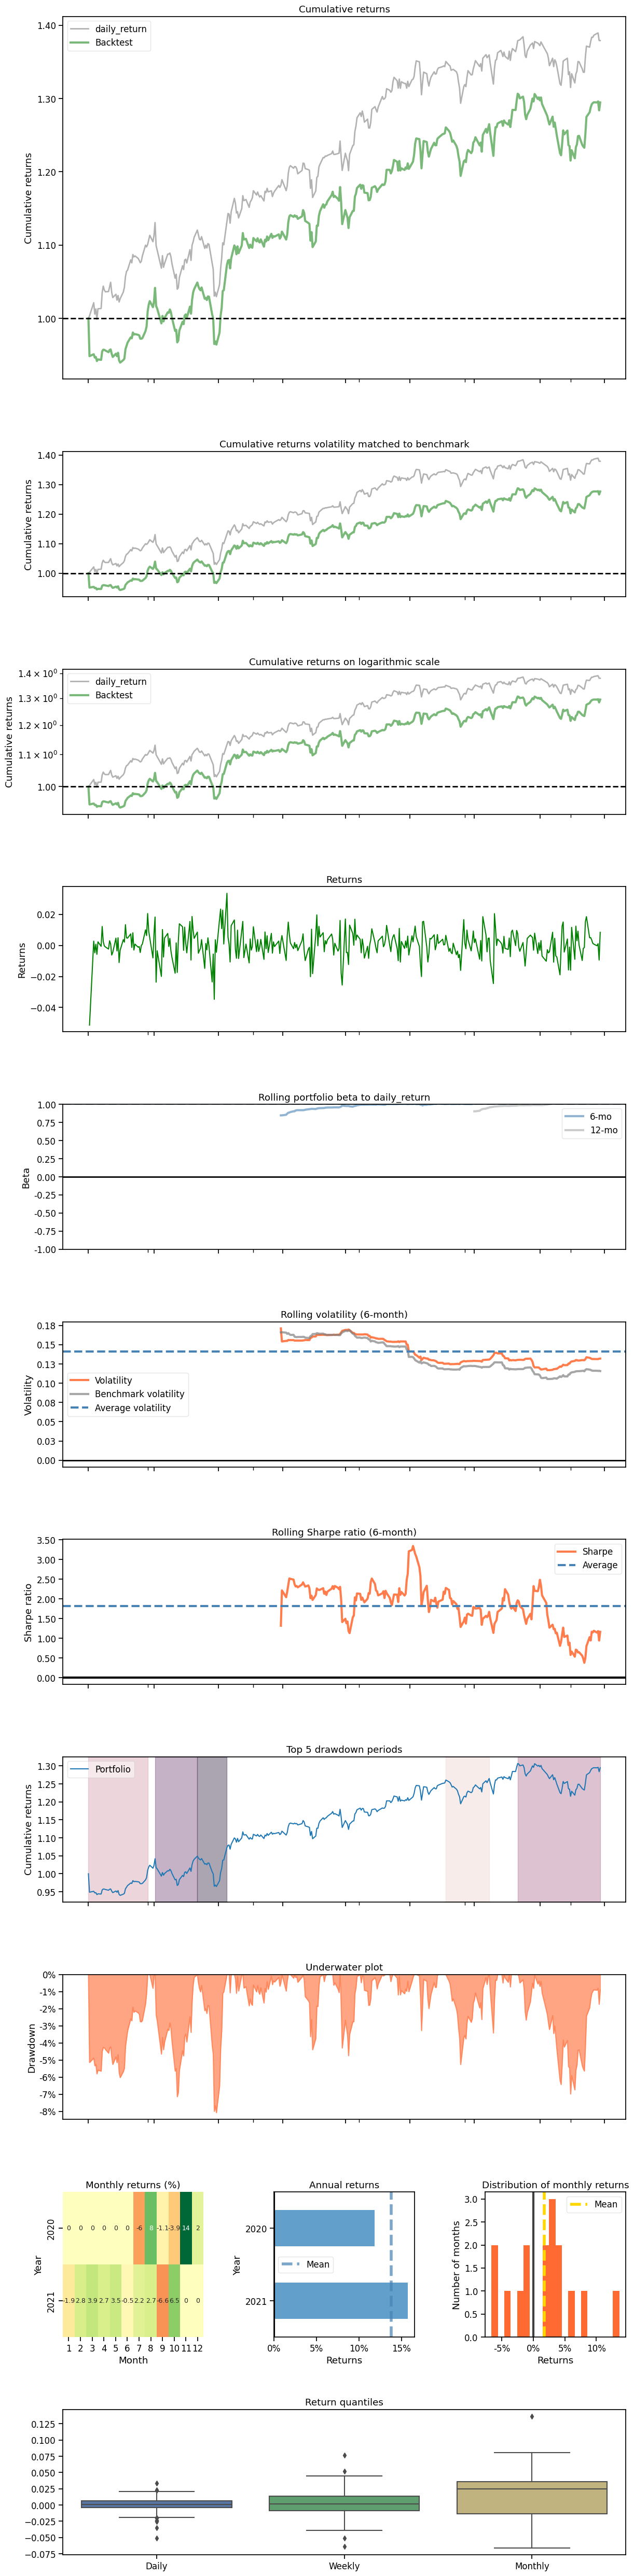

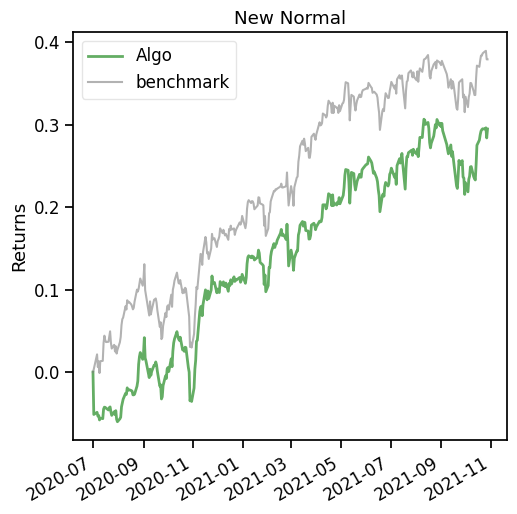

In [70]:
print("==============Compare to DJIA===========")
%matplotlib inline
# S&P 500: ^GSPC
# Dow Jones Index: ^DJI
# NASDAQ 100: ^NDX
backtest_plot(df_account_value, 
             baseline_ticker = '^DJI', 
             baseline_start = df_account_value.loc[0,'date'],
             baseline_end = df_account_value.loc[len(df_account_value)-1,'date'])